<a href="https://colab.research.google.com/github/daks4012/2020-2-AI/blob/master/20190708_%EB%B0%B1%EC%A2%85%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1번 회귀 문제 : 자동차 연비 예측

In [ ]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!pip install seaborn

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


### 데이터 구하기
먼저 데이터셋을 다운로드합니다.

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

문제를 간단하게 만들기 위해서 누락된 행을 삭제하겠습니다.

In [ ]:
dataset = dataset.dropna()

`"Origin"` 열은 수치형이 아니고 범주형이므로 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다:

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 데이터셋을 훈련 세트와 테스트 세트로 분할하기

이제 데이터를 훈련 세트와 테스트 세트로 분할합니다.

테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 데이터 조사하기

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴 보겠습니다.

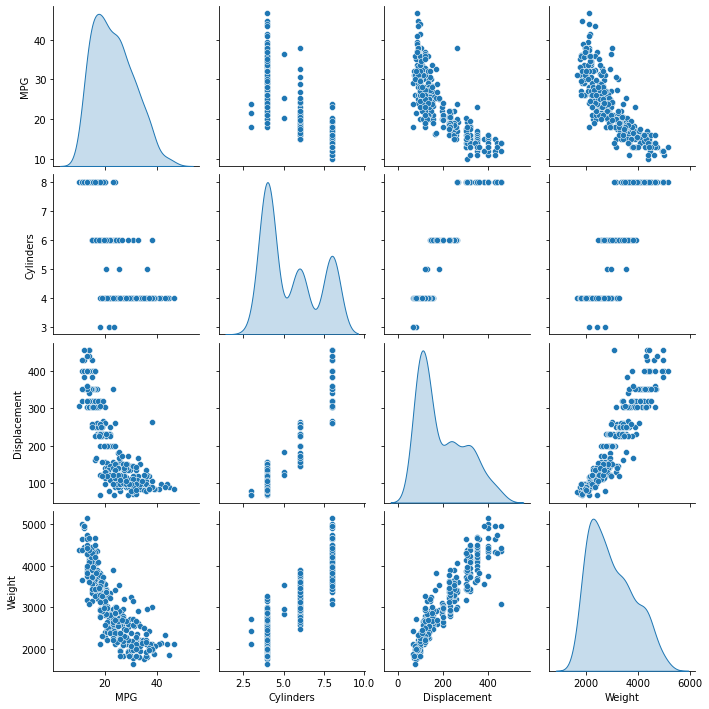

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계도 확인해 보죠:

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다. 이 레이블을 예측하기 위해 모델을 훈련시킬 것입니다.

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### 데이터 정규화

위 `train_stats` 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보죠.

특성의 스케일과 범위가 다르면 정규화(normalization)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 *수렴할 수 있지만*, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

노트: 의도적으로 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때에도 사용됩니다. 이는 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위해서입니다.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 데이터를 사용하여 모델을 훈련합니다.

주의: 여기에서 입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 원-핫 인코딩과 마찬가지로 모델에 주입되는 모든 데이터에 적용되어야 합니다. 여기에는 테스트 세트는 물론 모델이 실전에 투입되어 얻은 라이브 데이터도 포함됩니다.

## 모델

### 모델 만들기

모델을 구성해 보죠. 여기에서는 두 개의 완전 연결(densely connected) 은닉층으로 `Sequential` 모델을 만들겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다. 나중에 두 번째 모델을 만들기 쉽도록 `build_model` 함수로 모델 구성 단계를 감싸겠습니다.

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

### 모델 확인

`.summary` 메서드를 사용해 모델에 대한 간단한 정보를 출력합니다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한번 실행해 보죠. 훈련 세트에서 `10` 샘플을 하나의 배치로 만들어 `model.predict` 메서드를 호출해 보겠습니다.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.46751767],
       [-0.4236726 ],
       [-0.606946  ],
       [-0.52952176],
       [-0.5213115 ],
       [-0.25609094],
       [-0.5454    ],
       [-0.50950956],
       [-0.43021268],
       [-0.3437342 ]], dtype=float32)

제대로 작동하는 것 같네요. 결괏값의 크기와 타입이 기대했던 대로입니다.

### 모델 훈련

이 모델을 1,000번의 에포크(epoch) 동안 훈련합니다. 훈련 정확도와 검증 정확도는 `history` 객체에 기록됩니다.

In [ ]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해 보죠.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.466862,1.007511,2.466862,10.953683,2.574024,10.953683,995
996,2.388378,0.994588,2.388378,10.987843,2.583588,10.987843,996
997,2.314343,0.999833,2.314343,10.683765,2.535599,10.683765,997
998,2.483696,1.023487,2.483696,10.562189,2.542254,10.562189,998
999,2.568191,1.097927,2.568191,10.403732,2.529402,10.403732,999


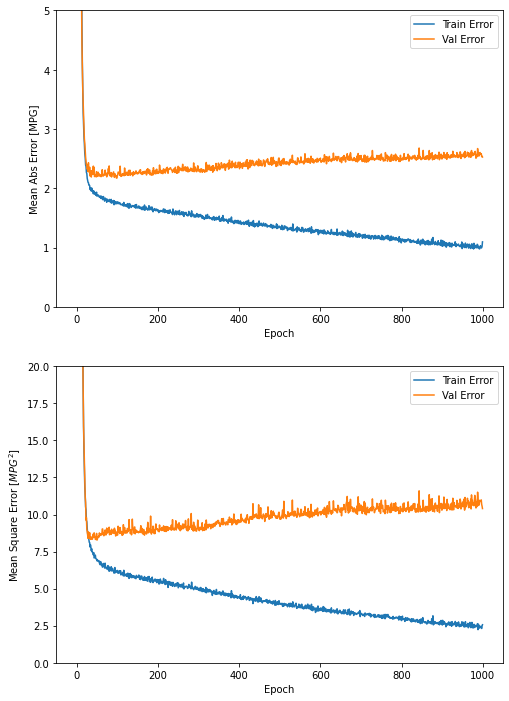

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

이 그래프를 보면 수 백번 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다. `model.fit` 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어 보죠. 에포크마다 훈련 상태를 점검하기 위해 *EarlyStopping 콜백(callback)*을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.

이 콜백에 대해 더 자세한 내용은 [여기](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping)를 참고하세요.


.............................................................................................

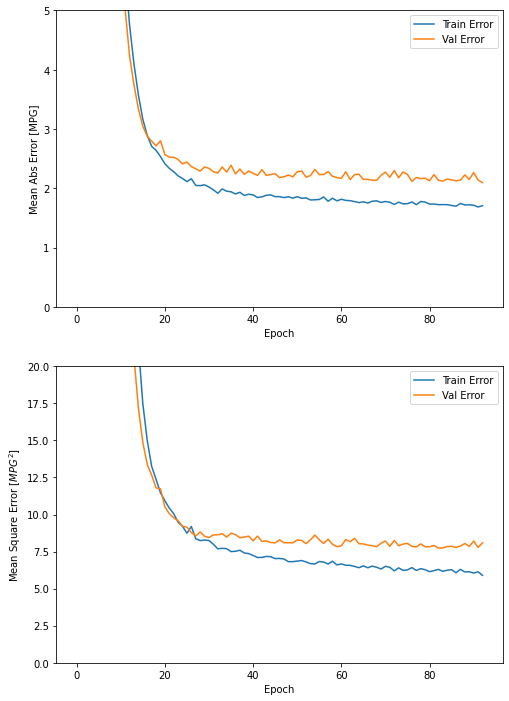

In [ ]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

이 그래프를 보면 검증 세트의 평균 오차가 약 +/- 2 MPG입니다. 좋은 결과인가요? 이에 대한 평가는 여러분에게 맡기겠습니다.

모델을 훈련할 때 사용하지 않았던 **테스트 세트**에서 모델의 성능을 확인해 보죠. 이를 통해 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다:

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.5187 - mae: 2.0091 - mse: 6.5187
테스트 세트의 평균 절대 오차:  2.01 MPG


## 예측

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다:

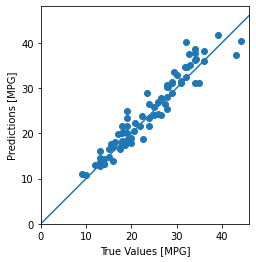

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


모델이 꽤 잘 예측한 것 같습니다. 오차의 분포를 살펴 보죠.

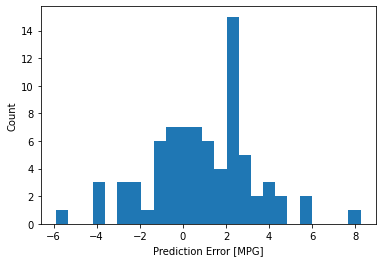

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

가우시안 분포가 아니지만 아마도 훈련 샘플의 수가 매우 작기 때문일 것입니다.

## 결론

이 노트북은 회귀 문제를 위한 기법을 소개합니다.

* 평균 제곱 오차(MSE)는 회귀 문제에서 자주 사용하는 손실 함수입니다(분류 문제에서 사용하는 손실 함수와 다릅니다).
* 비슷하게 회귀에서 사용되는 평가 지표도 분류와 다릅니다. 많이 사용하는 회귀 지표는 평균 절댓값 오차(MAE)입니다.
* 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
* 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 소규모 네트워크를 선택하는 방법이 좋습니다.
* 조기 종료(Early stopping)은 과대적합을 방지하기 위한 좋은 방법입니다.

# 2번 분류 문제 : Iris 붓꽃 분류

## Iris 데이터셋 다운로드<br>
X는 iris의 data darray<br>y는 labels

In [ ]:
from sklearn import datasets
import pandas as pd
from pandas import DataFrame

iris = datasets.load_iris()
X = iris.data #X는 iris의 data darray
y = iris.target #y는 labels
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
#Do preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
X_prepared = num_pipeline.fit_transform(X) #정제된 X

## 훈련 및 테스트 데이터 셋


In [ ]:
#training set & test set 나누기
from sklearn.model_selection import train_test_split
import numpy as np
X_train , X_test , y_train , y_test = train_test_split(X_prepared,y,test_size=0.2,random_state=42)

## 분류 모델 생성



In [ ]:
#첫번째 classification model : SGDClassifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=3, tol=-np.infty,random_state=42)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=3,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
#두번째 classification model : RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10,random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
#세번째 classification model : k-NeighborsClassifier
#k-NeighborsClassifier : 새로운 data에 대한 k개의 근접한 이웃을 찾는 알고리즘
from sklearn.neighbors import KNeighborsClassifier
knb_clf = KNeighborsClassifier(n_neighbors=1) #1개의 가장 근접한 이웃을 찾는다
knb_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## 교차 검증을 사용하여 정확도 얻기

In [ ]:
#Get Accuracy using cross validation
from sklearn.model_selection import cross_val_score
#accuracy 평가하는 함수
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [ ]:
#SGDclassifier cross_val
sgd_score=cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring="accuracy")
display_scores(sgd_score)

Scores: [0.58333333 0.91666667 0.75       1.         0.66666667 0.83333333
 1.         0.75       0.91666667 1.        ]
Mean: 0.8416666666666668
Standard deviation: 0.14166666666666664


In [ ]:
#RandomForestclassifier cross_val
forest_score=cross_val_score(forest_clf,X_train, y_train, cv=10, scoring="accuracy")
display_scores(forest_score)

Scores: [0.91666667 1.         1.         1.         0.66666667 0.83333333
 0.91666667 0.91666667 1.         0.91666667]
Mean: 0.9166666666666666
Standard deviation: 0.09860132971832694


In [ ]:
#k-NeighborsClassifier cross_val
knb_score=cross_val_score(knb_clf,X_train, y_train, cv=10, scoring="accuracy")
display_scores(knb_score)

Scores: [0.91666667 1.         1.         1.         0.75       0.83333333
 1.         1.         1.         0.91666667]
Mean: 0.9416666666666667
Standard deviation: 0.08374896350934075


## 그리드 서치를 이용해 하이퍼 파라미터 찾기



In [ ]:
#Grid Search
from sklearn.model_selection import GridSearchCV
param_grid_SGD=[
    {'max_iter':[2,3],
     'alpha':[0.0001,0.001,0.01,0.1,1]}
]
param_grid_forest=[
    {'n_estimators':[1,10,100,1000,10000],
     'max_depth':[1,3]}
]
param_grid_knb=[
    {'n_neighbors':[1,5,10,15,20,25,30,35,40,45] }
     #n_neighbors : int, optional (default = 5) -->Number of neighbors to use by default for kneighbors queries.
]

In [ ]:
#Accuracy를 출력하는 함수
def getAccuracy(grid):
    cvres =grid.cv_results_
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(mean_score, params)
    print('##########################################################')
    print('Best hyperparameter: {}'.format(grid.best_params_))
    print('Best accuracy of hyperparameter : {}'.format(grid.best_score_))

In [ ]:
#SGD Classifier의 accuracy using Grid Search
sgd_clf_1 = SGDClassifier(tol=-np.infty,random_state=42)
grid_SGD =GridSearchCV(sgd_clf_1, param_grid_SGD, scoring='accuracy', cv=10, n_jobs=-1)
grid_SGD.fit(X_train,y_train)
getAccuracy(grid_SGD)

0.8083333333333332 {'alpha': 0.0001, 'max_iter': 2}
0.8416666666666668 {'alpha': 0.0001, 'max_iter': 3}
0.8166666666666667 {'alpha': 0.001, 'max_iter': 2}
0.8833333333333334 {'alpha': 0.001, 'max_iter': 3}
0.8333333333333333 {'alpha': 0.01, 'max_iter': 2}
0.8833333333333334 {'alpha': 0.01, 'max_iter': 3}
0.8666666666666666 {'alpha': 0.1, 'max_iter': 2}
0.8666666666666666 {'alpha': 0.1, 'max_iter': 3}
0.7666666666666667 {'alpha': 1, 'max_iter': 2}
0.7666666666666667 {'alpha': 1, 'max_iter': 3}
##########################################################
Best hyperparameter: {'alpha': 0.001, 'max_iter': 3}
Best accuracy of hyperparameter : 0.8833333333333334


In [ ]:
#RandomForest Classifier의 accuracy using Grid Search
forest_clf_1 =RandomForestClassifier(random_state=42)
grid_forest = GridSearchCV(forest_clf_1, param_grid_forest, scoring='accuracy', cv=10, n_jobs=-1)
grid_forest.fit(X_train,y_train)
getAccuracy(grid_forest)

0.6583333333333334 {'max_depth': 1, 'n_estimators': 1}
0.825 {'max_depth': 1, 'n_estimators': 10}
0.9249999999999998 {'max_depth': 1, 'n_estimators': 100}
0.9083333333333332 {'max_depth': 1, 'n_estimators': 1000}
0.9249999999999998 {'max_depth': 1, 'n_estimators': 10000}
0.9499999999999998 {'max_depth': 3, 'n_estimators': 1}
0.9333333333333332 {'max_depth': 3, 'n_estimators': 10}
0.9333333333333332 {'max_depth': 3, 'n_estimators': 100}
0.9416666666666667 {'max_depth': 3, 'n_estimators': 1000}
0.9416666666666667 {'max_depth': 3, 'n_estimators': 10000}
##########################################################
Best hyperparameter: {'max_depth': 3, 'n_estimators': 1}
Best accuracy of hyperparameter : 0.9499999999999998


In [ ]:
#KNeighbors Classifier의 accuracy using Grid Search
knb_clf_1 = KNeighborsClassifier()
grid_knb =GridSearchCV(knb_clf_1, param_grid_knb, scoring='accuracy', cv=10, n_jobs=-1)
grid_knb.fit(X_train,y_train)
getAccuracy(grid_knb)

0.9416666666666667 {'n_neighbors': 1}
0.9416666666666667 {'n_neighbors': 5}
0.9416666666666667 {'n_neighbors': 10}
0.95 {'n_neighbors': 15}
0.9333333333333332 {'n_neighbors': 20}
0.9083333333333332 {'n_neighbors': 25}
0.8583333333333332 {'n_neighbors': 30}
0.8583333333333332 {'n_neighbors': 35}
0.8583333333333332 {'n_neighbors': 40}
0.8333333333333333 {'n_neighbors': 45}
##########################################################
Best hyperparameter: {'n_neighbors': 15}
Best accuracy of hyperparameter : 0.95


## Step6. 랜덤마이즈드를 사용해 하이퍼 파라미터 찾기

In [ ]:
#randomize search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random
param_distribs_SGD = {
        'max_iter':randint(low=1,high=20),
    }
param_distribs_forest = {
        'n_estimators': randint(low=1, high=200),
        'max_depth': randint(low=1, high=3),
    }
param_distribs_knb = {
        'n_neighbors':randint(low=1, high=95) }
     #n_neighbors : int, optional (default = 5) -->Number of neighbors to use by default for kneighbors queries.

In [ ]:
#SGD Classifier의 accuracy using Randomize Search
rnd_SGD = RandomizedSearchCV(sgd_clf_1, param_distributions=param_distribs_SGD,
                                n_iter=10, cv=5, scoring='accuracy', random_state=42)
rnd_SGD.fit(X_train,y_train)
getAccuracy(rnd_SGD)

0.8833333333333334 {'max_iter': 7}
0.9166666666666666 {'max_iter': 15}
0.9166666666666667 {'max_iter': 11}
0.8083333333333332 {'max_iter': 8}
0.8833333333333334 {'max_iter': 7}
0.9 {'max_iter': 19}
0.9166666666666667 {'max_iter': 11}
0.9166666666666667 {'max_iter': 11}
0.8833333333333332 {'max_iter': 4}
0.8083333333333332 {'max_iter': 8}
##########################################################
Best hyperparameter: {'max_iter': 11}
Best accuracy of hyperparameter : 0.9166666666666667


In [ ]:
#RandomForest Classifier의 accuracy using Randomize Search
rnd_forest = RandomizedSearchCV(forest_clf_1, param_distributions=param_distribs_forest,
                                n_iter=10, cv=5, scoring='accuracy', random_state=42)
rnd_forest.fit(X_train,y_train)
getAccuracy(rnd_forest)

0.8583333333333334 {'max_depth': 1, 'n_estimators': 180}
0.7833333333333332 {'max_depth': 1, 'n_estimators': 15}
0.8833333333333334 {'max_depth': 1, 'n_estimators': 72}
0.8333333333333333 {'max_depth': 1, 'n_estimators': 21}
0.8583333333333334 {'max_depth': 1, 'n_estimators': 122}
0.8416666666666666 {'max_depth': 1, 'n_estimators': 75}
0.825 {'max_depth': 1, 'n_estimators': 88}
0.8583333333333334 {'max_depth': 1, 'n_estimators': 100}
0.9333333333333333 {'max_depth': 2, 'n_estimators': 152}
0.8583333333333334 {'max_depth': 1, 'n_estimators': 150}
##########################################################
Best hyperparameter: {'max_depth': 2, 'n_estimators': 152}
Best accuracy of hyperparameter : 0.9333333333333333


In [ ]:
#KNeighbors Classifier의 accuracy using Randomize Search
rnd_knb = RandomizedSearchCV(knb_clf_1, param_distributions=param_distribs_knb,
                                n_iter=10, cv=5, scoring='accuracy', random_state=42)
rnd_knb.fit(X_train,y_train)
getAccuracy(rnd_knb)

0.8083333333333332 {'n_neighbors': 52}
0.4083333333333333 {'n_neighbors': 93}
0.95 {'n_neighbors': 15}
0.6416666666666666 {'n_neighbors': 72}
0.8166666666666667 {'n_neighbors': 61}
0.9166666666666667 {'n_neighbors': 21}
0.4416666666666666 {'n_neighbors': 83}
0.425 {'n_neighbors': 87}
0.55 {'n_neighbors': 75}
0.55 {'n_neighbors': 75}
##########################################################
Best hyperparameter: {'n_neighbors': 15}
Best accuracy of hyperparameter : 0.95


##정확도와 리콜 계산

In [ ]:
#Calculate Precision and Recall
from sklearn.metrics import precision_score,recall_score
def getPR(classifier):
    y_score = classifier.predict(X_test)
    precision = precision_score(y_test, y_score,average='micro')
    #Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    recall =  recall_score(y_test, y_score,average='micro')
    print('precision score: {}'.format(precision))
    print('recall score: {}'.format(recall))

In [ ]:
getPR(sgd_clf)

precision score: 0.9666666666666667
recall score: 0.9666666666666667


In [ ]:
getPR(forest_clf)

precision score: 1.0
recall score: 1.0


In [ ]:
getPR(knb_clf)

precision score: 0.9666666666666667
recall score: 0.9666666666666667


# 3번 CNN 문제 : CIFAR-10 분류

고양이와 강아지 사진 분류

## 데이터 수집 (Data Collection)

모델 훈련을 위해서 CIFAR10에서 고양이와 강아지의 이미지를 골라서 사용한다.

In [ ]:
from tensorflow.keras.datasets import cifar10

(train_image, train_label), (test_image, test_label) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
import numpy as np
import pandas as pd

CAT_VALUE = 3
DOG_VALUE = 5

condition_train = (train_label[:,0]==CAT_VALUE) | (train_label[:,0]==DOG_VALUE)
condition_test = (test_label[:,0]==CAT_VALUE) | (test_label[:,0]==DOG_VALUE)

x_train = train_image[condition_train]
y_train = train_label[condition_train]
x_test = test_image[condition_test]
y_test = test_label[condition_test]

print('x_train shape is ', x_train.shape)
print('y_train shape is ', y_train.shape)
print('\nx_test shape is ', x_test.shape)
print('y_test shape is ', y_test.shape)

x_train shape is  (10000, 32, 32, 3)
y_train shape is  (10000, 1)

x_test shape is  (2000, 32, 32, 3)
y_test shape is  (2000, 1)


## 데이터 분석 (Data Analysis)

고양이와 강아지의 데이터셋은 다음과 같다.

- x_train: 32x32x3(RGB), 10,000개의 훈련을 위한 고양이와 강아지의 이미지  
- y_train: 10,000개의 이미지를 고양이(3), 강아지(5)의 두가지 정수 값으로 라벨링
- x_test: 32x32x3(RGB), 2,000개의 테스트를 위한 고양이와 개의 이미지
- y_test:  2,000개의 이미지를 고양이(3), 강아지(5)의 두가지 정수 값으로 라벨링

10개의 훈련 이미지와 레이블은 아래와 같다.  

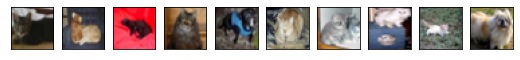

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(9,90))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
y_train[:10]

array([[3],
       [3],
       [3],
       [3],
       [5],
       [3],
       [3],
       [3],
       [3],
       [5]], dtype=uint8)

> 컬러(RGB)이미지의 모든 픽셀값을 피쳐(특징값)로 사용하는 것은 무리입니다.
> 다른 방안으로 Edge Detection 사용
### Edge Detection

엔지니어들은 이미지의 특징을 추출하기 위해서 컨벌루션(Convolution)이라는 기법을 개발했다.  
컨벌루션은 이미지에 3X3이나 5X5 필터를 오른쪽과 아래로 이동하며 적용하는 기술이다.  

필터에 들어가는 값에 따라서 다양한 이미지의 특징들을 보여준다.  

아래는 sobel_h, sobel_v 필터링 적용 예다.  

$sobel_h = \begin{bmatrix}
1 & 2 & 1  \\
0 & 0 & 0  \\
-1 & -2 & -1
\end{bmatrix}
\quad
sobel_v =  \begin{bmatrix}
1 & 0 & -1  \\
2 & 0 & -2  \\
1 & 0 & -1
\end{bmatrix}$  

왼쪽은 원본 이미지, 중간은 물체의 가로 경계선이 강조되는 sobel_h 필터를 적용한 이미지, 오른쪽은 물체의 세로 경계선이 강조되는 sobel_v 필터를 적용한 이미지다.  

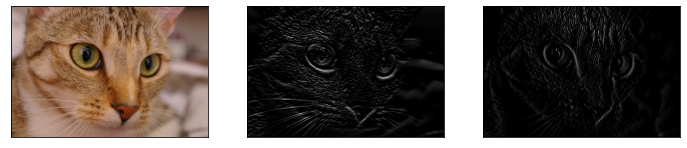

In [ ]:
from skimage.data import chelsea
from skimage.filters import sobel_h, sobel_v
from skimage.color import rgb2gray

# INPUT
image = chelsea()
grey_image = rgb2gray(image)

# CONV
edge_h = sobel_h(grey_image)
edge_v = sobel_v(grey_image)

# ReLU
edge_h = np.where(edge_h < 0, 0, edge_h)
edge_v = np.where(edge_v < 0, 0, edge_v)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(edge_h, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(edge_v, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([])
plt.show()


## CNN 모델링 (CNN Modeling)

### Convolutional Layer

이미지에 컨벌루션(Convolution)을 수행하는 레이어다.  
필터의 개수, 필터의 크기, 패딩 방법을 정의한다.  
예를 들어서 (32, 32, 3) 이미지에 (3, 3) 필터 64개를 적용하면 (30, 30, 64)의 이미지가 출력 된다.    
입력 이미지와 출력 이미지의 해상도가 달라지는 것을 방지하기 위해서 패딩(Padding)을 입력 이미지에 적용한다.  

#### 필터 (Filter)

일반적으로 3X3, 5X5 필터를 사용한다.  
보통 필터의 개수는 레이어가 추가될 때마다 두배로 늘린다.

#### 패딩 (Padding)

입력 이미지 매트릭스의 상하, 좌우로 '0'을 추가하는 것을 패딩이라고 한다.  
$f$를 필터 사이즈라고 하고 $p$를 패딩 사이즈라고 하면, 입력 이미지와 출력 이미지의 해상도를 같게 해 주기 위해서는  
$p= \dfrac{f-1}{2}$ 로 한다.  

예를 들어서 (32, 32, 3) 이미지에 (3, 3) 필터 64개를 적용하고 패딩을 1로 하면 (32, 32, 64)의 이미지가 출력 된다.

### Activation Layer

0보다 작은 값은 0으로 만들어서 사물의 경계선만을 특징으로 선택한다. 따라서 렐루(ReLU)를 사용한다.  

### Pooling Layer

보통 레이어가 추가될 때마다 필터 개수는 두배로 늘리고 해상도는 반으로 줄이도록 설계를 한다.
사물의 특징을 보존하면서 해상도를 줄이는 역활을 수행한다.  
Max pooling은 필터값이 없는 윈도우가 이미지 위에서 이동하면서 내부의 값들 중에 최대값을 선택하는 방식이다.  

![Pooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

출처: [cs231n Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/)

#### Dropout

과대적합(Overfitting)을 방지하기 위한 방법으로서 주어진 확률로 랜덤하게 유닛(unit)을 선택해서 꺼버린다.  
예를 들어 레이어의 유닛 수가 32개이고 Dropout의 확률이 0.25이면 입력이 들어올 때마다 8개의 유닛을 랜덤하게 선택해서 꺼버린다.  
훈련 과정에서만 적용해야 한다.  

### FC Layer

히든 레이어(Hidden layer)로서 모든 유닛이 빠짐없이 연결되어 있다.  
Fully Connected Layer로서 덴스(Dense)하게 연결 되어 있다는 뜻. 

### Output Layer

고양이냐 강아지냐, 0과 1의 문제임으로 시그모이드 함수를 사용한다.  

### 정리  

1. CONV = 3X3 filter, padding = 'same', activation='relu' 로 정의한다.
2. [CONV 32] X2 : 32개의 필터로 CONV를 두번 수행한다.  
3. POOL = 2X2 window, dropout = 0.25 로 정의한다.  
4. [POOL] : POOL을 수행한다. 1/4 확률로 랜덤하게 유닛을 꺼버린다.    
5. [CONV 64] X2 : 64개의 필터로 CONV를 두번 수행한다.  
6. [POOL] : POOL을 수행한다. 1/4 확률로 랜덤하게 유닛을 꺼버린다. 
7. FC = activation='relu', 3. dropout = 0.25 로 정의한다.  
8. [FC 512] : 512개의 units로 뉴럴 네트워크 레이어를 정의한다. 1/4 확률로 랜덤하게 유닛을 꺼버린다. 
8. [OUTPUT] : 시그모이드(Sigmoid)로 출력 레이어를 정의한다.


## 케라스(Keras)로 모델링(Modeling)

### 데이터 변환 (Data Transformation)

#### 정규화 (Normalization)

입력 이미지에 대해서 `정규값 = (현재값 - 최소값) / (최대값-최소값)` 으로 정규화 한다.


In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#### 이진 분류 (Binary Classification)

고양이냐 강아지냐를 선택하는 0과 1의 문제다. 따라서 출력 레이어(output layer)의 활성화 함수(activation function)는 당근 시그모이드(Sigmoid)를 사용한다. 따라서 고양이를 0, 강아지를 1로 변환한다.  

In [ ]:
y_train = np.where(y_train==3, 0, 1)
y_test = np.where(y_test==3, 0, 1)

### 모델링 (Modeling)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import os

save_dir = os.getcwd()
model_name = 'keras_catdog_trained_model.h5'

batch_size = 32
epochs = 100

model = Sequential()
# CONV 32 X2
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
# POOL
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV 64 X2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
# POOL
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Vectorize
model.add(Flatten())
# FC 512
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# OUTPUT
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


### 모델 훈련 (Train Model)

모델의 훈련 결과를 파일로 저장해서 필요할 때 재훈련 없이 불러서 사용할 수 있다.

* 오래걸립니다.

In [ ]:
hist = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              shuffle=True,
              verbose=0)

# Save model and weights
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

train_accuracy = hist.history['accuracy'][-1]
train_loss =  hist.history['loss'][-1]

print('train accuracy: ', train_accuracy)
print('train loss: ', train_loss)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(hist.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 정확도 평가 (Test Model)

훈련 정확도와 테스트 정확도의 차이가 많이 납니다.  
과대적합(Overfitting) 현상이다.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

In [ ]:
import pandas as pd

df = pd.DataFrame(data=[[train_accuracy, test_acc]], 
                  index = ['CNN'],
                  columns=['train accuracy', 'test accuracy'])
df

## 해결 (Solution)

In [ ]:
from  tensorflow.keras.models import load_model
import os

load_dir = os.getcwd()
model_name = 'keras_catdog_trained_model.h5'
model_path = os.path.join(load_dir, model_name)

pick_image = 30 # 0 ~ 1,999

def predict_catdog(x, model):
    x_data =(np.expand_dims(x, 0))
    predict = model.predict(x_data)
    #print(predict)
    if predict < 0.5:
        return 'cat'
    else:
        return 'dog'

test_data = x_test[pick_image]
model = load_model(model_path)

result = predict_catdog(test_data, model)

plt.figure(figsize=(2,2))
plt.imshow(test_data)
plt.xticks([])
plt.yticks([])
plt.show()
print('This is a ', result)